In [33]:
import os
import pandas as pd
import sqlite3 as sqlite
import numpy as np
import random


from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score,accuracy_score, precision_score, recall_score, classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.utils import shuffle
from sklearn.model_selection import cross_val_predict, cross_val_score
import pickle

In [21]:
DATADIR = '../stats_data'
DB = os.path.join(DATADIR, 'Reference Standard', 'radiology_reports.sqlite')
os.path.exists(DB)

True

# Introduction
This notebook is an expansion on `Report Classification.ipynb`. That notebook aimed to test a number of ML classifiers with different hyperparemeters on a task of document classification. That found that the highest-performing algorithm for our task was a `Logistic Regression` classifier.


This notebook will aim to compare this classifier with a number of lower performing algorithms and random guessing. We will follow methods laid out here:
https://www.cs.waikato.ac.nz/ml/publications/2003/bouckaert-calibrated-tests.pdf

## 1. Statistical Significance Test for ML predictions
Now that we have identified a Machine Learning classifier that we believe can effectively identify reports that contain fluid collections, the first thing to do is test that these predictions are statistically significant. To do this, we'll compare the ML predictions of the two different populations using a Student's T-Test. If the resulting p-value is very low, then that would mean that the ML predictions are very unlikely to happen by chance and are statistically significant. Otherwise, then there is a high likelihood that the predictions could be random and are thus not statistically significant.

In [36]:
preds = pd.read_csv('../stats_data/test_preds.txt', sep='\t')
preds.head()

,Unnamed: 0,name,doc_class,pred
0,0,No_1007_141227_06-18-95,0,0
1,1,No_12344_140694_08-13-21,0,0
2,2,No_14176_126791_10-19-39,0,0
3,3,No_15847_121459_06-07-77,0,0
4,4,No_15847_121459_06-16-77,0,0


In [37]:
# Let's view its overall performance
print(classification_report(preds.doc_class, preds.pred))

             precision    recall  f1-score   support

          0       0.88      0.96      0.92        69
          1       0.88      0.71      0.79        31

avg / total       0.88      0.88      0.88       100



In [38]:
pos_docs = preds[preds["doc_class"] == 1]
neg_docs = preds[preds["doc_class"] == 0]

In [39]:
ttest(pos_docs.pred, neg_docs.pred)

Ttest_indResult(statistic=10.025252207210642, pvalue=1.0667818681322787e-16)

### 1 - Results
Comparing our predictions on the two populations yields a p-value of < 0.001. This shows that our algorithm yields results that are statistically significant.

# 2 - Comparing Significance of Difference Between Different Algorithms
We now know that ML can offer an effective solution to identifying reports with fluid collections. In the last notebook we trained a number of different algorithms and picked the algorithm with the highest F1. In this notebook we'll compare the algorithm we picked with a number of other classifiers and random guessing.

## 2-a - Data Preparation
Instead of using test/train splits, this notebook will use cross-validation in order to maximize the amount of data for each fold.

In [40]:
conn = sqlite.connect(DB)

# Training data
train_df = pd.read_sql("SELECT * FROM training_notes;", conn)
#Testing data
test_df = pd.read_sql("SELECT * FROM testing_notes;", conn)
conn.close()

In [41]:
df = train_df.append(test_df)
df.head()

,rowid,name,text,referenceXML,doc_class,subject,HADM_ID,CHARTDATE
0,1,No_10792_131562_05-29-20,\n CT ABDOMEN W/CONTRAST; CT PELVIS W/CONTRAS...,"<?xml version=""1.0"" encoding=""UTF-8""?>\n<annot...",0,32,131562,05-29-20
1,2,No_11050_126785_11-03-33,\n CT CHEST W/CONTRAST; CT ABDOMEN W/CONTRAST...,"<?xml version=""1.0"" encoding=""UTF-8""?>\n<annot...",0,34,126785,11-03-33
2,3,No_11879_166554_06-22-37,\n CTA CHEST W&W/O C &RECONS; CT 100CC NON IO...,"<?xml version=""1.0"" encoding=""UTF-8""?>\n<annot...",0,35,166554,06-22-37
3,4,No_11879_166554_06-23-37,\n CT ABDOMEN W/O CONTRAST; CT PELVIS W/O CON...,"<?xml version=""1.0"" encoding=""UTF-8""?>\n<annot...",0,35,166554,06-23-37
4,5,No_11879_166554_07-02-37,\n CT CHEST W/O CONTRAST \n ~ Reason: r/o ste...,"<?xml version=""1.0"" encoding=""UTF-8""?>\n<annot...",0,35,166554,07-02-37


In [42]:
vectorizer = TfidfVectorizer(min_df=0.1, lowercase=True, stop_words='english',
                                     ngram_range=(1, 3))
X = list(df.text)
y = list(df.doc_class)

# Fit the vectorizer and transform the training notes into a vector
X = vectorizer.fit_transform(X)

In [43]:
X, y = shuffle(X, y)

## 2-b - Train Models
We will now instantiate our classifiers that we want to compare.

- Optimal Logistic Regression: highest-performing model from our last experiment
- RandomForestClassifier - the second-highest model
- Naive bayes
- SVM

As well as two low-performing classifiers that we would expect to perform poorly, just to compare against ours.
- Dummy Classifier: Randomly predicts based on class distribution
- Lowest - the lowest non-zero performing ML classifier

In [44]:
optimal = LogisticRegression(penalty='l1', C=1.0)
forest = RandomForestClassifier(n_estimators=200, max_depth=None, max_features='sqrt', n_jobs=-1)
naive = MultinomialNB()
svm = LinearSVC(C=0.05)
dummy = DummyClassifier()
lowest = LogisticRegression(penalty='l1', C=0.1)

clfs = [("Dummy Classifier", dummy), ("Random Forest", forest), ("Naive Bayes", naive), ("Worst Model", lowest), ("SVM", svm)]

# Experiment
We will now follow a number of different methods for comparing the performance of these algorithms.

### k-fold cross validation
(see paper)
"""
**Summary**: In k-fold cross validation, the data is split in k equal parts. The algorithm is then trained on all data but one fold. That remaining fold is used to test. This gives us *k* accuracy estimates for algorithms A and B.

xi is the difference between the two accuracies. The mean x is normally distributed if the algortihms are the same and the folds are sufficiently large.

We have a statistic approximating the t distribution with df = k - 1 degrees of freedom.
"""

In this section, we will do 10-fold cross-validation, which returns an array of 10 F1 scores for each classifer. For each of the non-optimal classifiers (not the Random Forest that we determined was the highest-performing model in the last notebook), we will compare the two arrays of F1 scores and see if they are significantly different.

In [48]:
# Now do a t-test
from scipy.stats import ttest_ind as ttest

def compare_model_results(clf1, clf2, X, y, k=10):
    """
    Compares the cross-validated accuracy scores of two different classifiers
    using a student's t-test.
    Returns the results of the t-test
    clf1: the first classifier
    clf2: the second classifier
    """
    results1 = cross_val_score(clf1, X, y, cv=k, scoring='f1')
    results2 = cross_val_score(clf2, X, y, cv=k, scoring='f1')
    f1_1 = np.mean(results1)
    f1_2 = np.mean(results2)
    return ttest(results1, results2), f1_1, f1_2
    

In [55]:
results = [] # This will hold the scores of the classifiers we are comparing
f1_optimals = [] # This will hold the F1 scores of our optimal model

In [56]:
for (name, clf) in clfs:
    print(name)
    t, f1_optimal, f1_clf = compare_model_results(optimal, clf, X, y, k=10)
    pvalue = t.pvalue
    results.append((name, pvalue, f1_clf))
    f1_optimals.append(f1_optimal)
    


Dummy Classifier
Random Forest
Naive Bayes
Worst Model
SVM


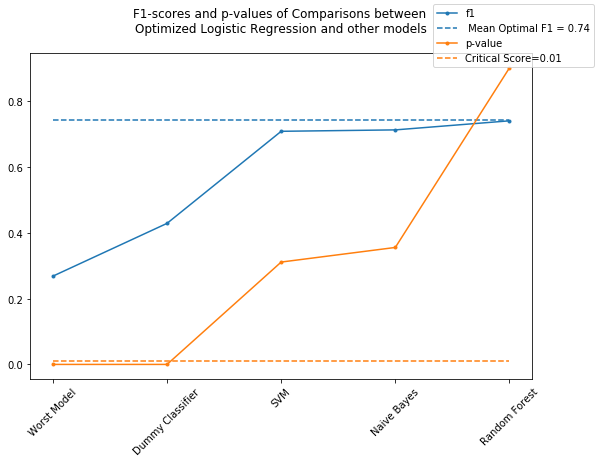

In [110]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots()
# Sort from highest F1 to lowest
sorted_results = sorted(results, key=lambda x:x[2], reverse=False)
names, pvalues, f1s = zip(*sorted_results)

# Now plot the P-values and F1 scores for each classifier
# F1's
ax.plot(range(len(f1s)), f1s, marker='.', label='f1', color='#1f77b4')
ax.plot(range(len(f1s)), [np.mean(f1_optimals) for i in range(len(pvalues))], label=' Mean Optimal F1 = 0.74',
       color='#1f77b4', linestyle='--')

# P-Values
ax.plot(range(len(pvalues)), pvalues, label='p-value', marker='.', color='#ff7f0e')
ax.plot(range(len(pvalues)), [0.01 for i in range(len(pvalues))], label='Critical Score=0.01', linestyle='--',
       color='#ff7f0e')

# Plot the optimal score
# ax.plot(5, np.mean(f1_optimals), marker='^', markersize=12)

ax.set_title("F1-scores and p-values of Comparisons between \nOptimized Logistic Regression and other models\n")
fig.legend()
# Change size
fig.set_figheight(fig.get_figheight() * 1.5)
fig.set_figwidth(fig.get_figwidth() * 1.5)
# ax.set_ylabel("p-value")
_ = plt.xticks(range(len(pvalues)), names, rotation=45)

# Conclusion
This notebook shows that the an ML classifier can predict whether or not a fluid collection is present in a document with statistical significance (p < 0.001). Our best model is a Logistic Regression classifier with a precision of 0.88 and recall of 0.71 and f1 of 0.79. This model outperforms random guessing and the worst model from our set of trained models.

However, when comparing against other high-performing models, our model is not significantly better than an SVM, Naive Bayes, or Random Forest. With this in mind, I would actually choose the Random Forest as the optimal model, as the p-value between the two models is very high (0.9) and, although the F1 is slightly worse (`Report Classification.ipynb` showed it to be 0.78), the precision and recall are better balanced (0.82, 0.74 respectively).

In conclusion, statistical and ML methods can effectively classify documents for this task. Using conditional probablities and Chi2 tests can reveal the terms that are most likely to indicate a positive document. Machine Learning algorithms can be trained that yield statistically significant results. Testing for the significance between different classifiers led us to choose the classifier with the second-highest F1 due to the better balance between precision and recall. 